<a href="https://colab.research.google.com/github/trantoan62/AI_FinalReport/blob/main/Predict_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall h5py -y
!pip install h5py==2.10.0
!pip uninstall numpy -y
!pip install numpy==1.16.4
!pip uninstall scikit-image -y
!pip install scikit-image==0.16.2
!pip install --no-deps tensorflow==1.15.3
!pip install --no-deps keras==2.2.4

In [ ]:
 !git clone https://github.com/matterport/Mask_RCNN.git
 %cd Mask_RCNN
!pip install -r requirements.txt
!python setup.py install
%cd ..

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

Using TensorFlow backend.


In [ ]:
import cv2
import sys

In [ ]:
from IPython.display import display, Javascript, Image

def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Bấm vào video để dừng</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; 
      captureCanvas.height = 480; 
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
class CowDataset(Dataset):
  def load_dataset(self, dataset_dir, is_train=True):
    self.add_class("dataset", 1, "cow")
    images_dir = dataset_dir + '/data/'
    annotations_dir = dataset_dir + '/label/'
    for filename in listdir(images_dir):
      image_id = filename[4:-6]
      img_path = images_dir + filename
      ann_path = annotations_dir + 'cow(' + image_id + ').xml'
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
      
  def extract_boxes(self, filename):
      tree = ElementTree.parse(filename)
      root = tree.getroot()
      boxes = list()
      for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
      width = int(root.find('.//size/width').text)
      height = int(root.find('.//size/height').text)
      return boxes, width, height

  def load_mask(self, image_id):
      info = self.image_info[image_id]
      path = info['annotation']
      boxes, w, h = self.extract_boxes(path)
      masks = zeros([h, w, len(boxes)], dtype='uint8')
      class_ids = list()
      for i in range(len(boxes)):
        box = boxes[i]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(self.class_names.index('cow'))
      return masks, asarray(class_ids, dtype='int32')
      
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_set = CowDataset()
train_set.load_dataset('/content/drive/MyDrive/cow', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 250


In [ ]:
class PredictionConfig(Config):
	NAME = "cow_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [ ]:
cfg = PredictionConfig()
%cd /content/drive/MyDrive
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights('mask_rcnn_cow_cfg_0003.h5', by_name=True)

In [ ]:
def plot_actual_vs_predicted(dataset, model, cfg, i):
	image = dataset.load_image(i)
	mask, class_ids = dataset.load_mask(i)
	scaled_image = mold_image(image, cfg)
	sample = expand_dims(scaled_image, 0)
	yhat = model.detect(sample, verbose=0)[0]
	pyplot.imshow(image)
	pyplot.title('Predicted')
	ax = pyplot.gca()
	biendemtam = 0
	for box in yhat['rois']:
		y1, x1, y2, x2 = box
		width, height = x2 - x1, y2 - y1
		rect = Rectangle((x1, y1), width, height, fill=False, color='red')
		ax.add_patch(rect)
		biendemtam += 1
	pyplot.show()
	print("There are " + str(biendemtam) + " cows on this picture")
	bbox = extract_bboxes(mask)
	display_instances(image, bbox, mask, class_ids, train_set.class_names)

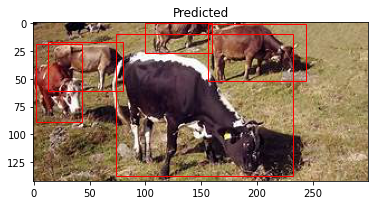

There are 5 cows on this picture


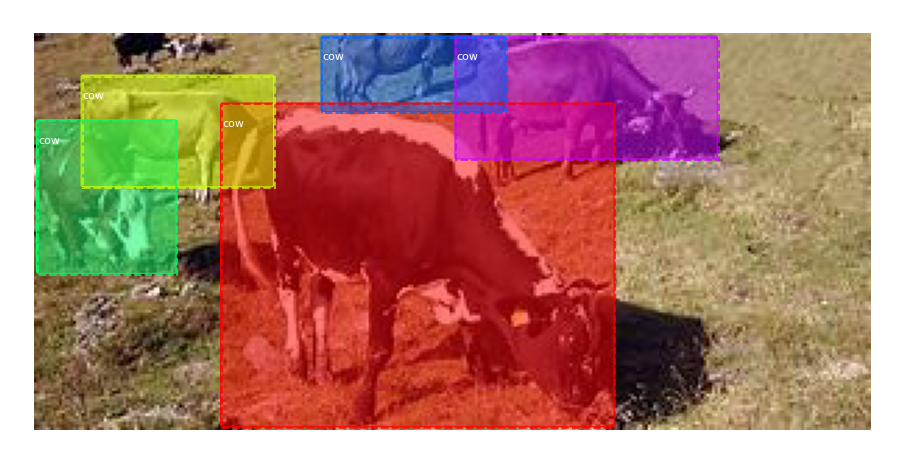

In [ ]:
plot_actual_vs_predicted(train_set, model, cfg, 102)

In [ ]:
%cd /content
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import cv2
from keras.models import  load_model

def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

/content


<IPython.core.display.Javascript object>

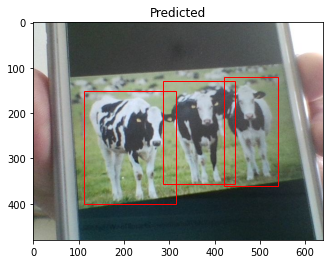

There are 3 cows on this picture


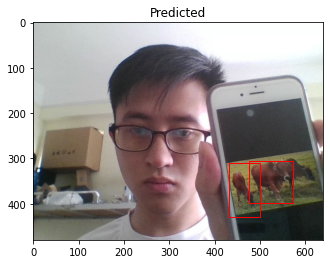

There are 2 cows on this picture


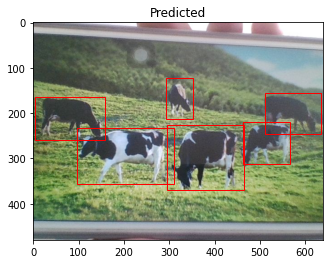

There are 6 cows on this picture


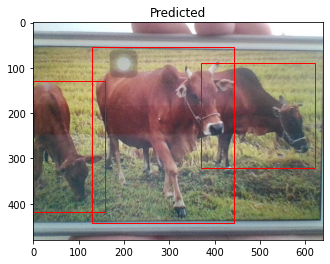

There are 3 cows on this picture


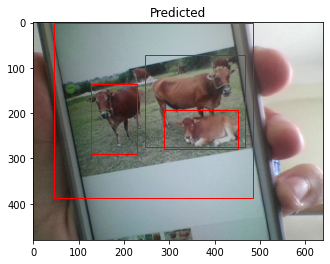

There are 4 cows on this picture


KeyboardInterrupt: ignored

In [ ]:
video_stream()
label_html1 = 'Lấy ảnh sau 5s'
label_html2 = 'Đang lấy hình ảnh...'
label_html3 = 'Đang xử lý ảnh'
bbox = ''
from time import sleep
while True:
    js_reply = video_frame(label_html1, bbox)
    if not js_reply:
        break
    sleep(5)
    js_reply = video_frame(label_html2, bbox)
    img = js_to_image(js_reply["img"])
    js_reply = video_frame(label_html3, bbox)
    image = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    scaled_image = mold_image(image, cfg)
    sample = expand_dims(scaled_image, 0)
    yhat = model.detect(sample, verbose=0)[0]
    pyplot.imshow(image)
    pyplot.title('Predicted')
    ax = pyplot.gca()
    biendemtam = 0
    for box in yhat['rois']:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      ax.add_patch(rect)
      biendemtam += 1
    pyplot.show()
    print("There are " + str(biendemtam) + " cows on this picture")